In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print('Location:', torch.__file__) # /home/emre/.local/lib/python3.7/site-packages

1.12.0+cu102
True
10.2
Location: /home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/torch/__init__.py


/home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [3]:
import warnings
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torchsummary import summary
import torchvision
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax

In [4]:
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
!CUDA_LAUNCH_BLOCKING=1
torch.cuda.set_device(2)
print('Num GPU:', torch.cuda.device_count())
print('Current device:', torch.cuda.current_device())
print('Device name:', torch.cuda.get_device_name())

Num GPU: 3
Current device: 2
Device name: TITAN V


In [5]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

## Dataloader

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        temp_x = torch.tensor(self.x[idx], dtype=torch.float)
        temp_y = torch.tensor(self.y[idx], dtype=torch.long)
#         self.x = self.x[idx]
#         self.y = self.y[idx]
#         return self.x[idx], self.y[idx] 
        return temp_x, temp_y

## Classify vid

In [7]:
%matplotlib inline
def train( model, model_name, prog_bar = True):
    
    max_test_acc = -1
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        train_acc = []
        test_acc = []
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
        
        # train
        for data in pbar:
            x, labels = data
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, labels)
            train_loss += loss.cpu().detach().numpy()/len(train_loader)
            loss.backward()
            optimizer.step()
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = labels.cpu().detach().numpy()
#             print('preds', preds)
#             print('labels', labels)
            
            acc = np.sum(preds == labels) / len(labels) * 100
            train_acc.append(acc)
            if prog_bar:
                pbar.set_description('Train_acc: '+str(round(acc,2)))
        train_accs.append(np.mean(train_acc))
        
        # test
        all_preds = []
        for data in test_loader:
            x, labels = data
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, labels)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = labels.cpu().detach().numpy()
            acc = np.sum(preds == labels) / len(labels) * 100
            test_acc.append(acc)
            all_preds.append(preds)
        test_accs.append(np.mean(test_acc))
        
        if np.mean(test_acc) > max_test_acc:
#             print(np.array(all_preds[0]).shape)
#             print(np.array(all_preds[1]).shape)
            best_preds = [i for a in all_preds for i in a]
            max_test_acc = np.mean(test_acc)
            torch.save(model.state_dict(), '../models/' + model_name + str(round(max_test_acc, 2)) + '.pth')
        
#         lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2))
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)

        
        lr_scheduler.step(train_loss)
        if not prog_bar:
            clear_output(wait=True)
            print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2),
                 ', Best Testing Acc:', round(max_test_acc, 2))
            plt.plot(train_accs, label="Train Acc")
            plt.plot(test_accs, label="Validation Acc")
            plt.xlabel("# Epoch")
            plt.ylabel("Accuracy")
            plt.legend(loc='upper right')
            plt.show()
    return best_preds

In [8]:
class CNN3D(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D
#         self.conv = nn.Sequential(nn.Conv2d(3, 32, 3),
#                                   nn.MaxPool2d(2, 2),
                                  
#                                   nn.Conv2d(32, 64, 3),
#                                   nn.MaxPool2d(2, 2),
                                  
#                                   nn.Conv2d(64, 128, 3),
#                                   nn.MaxPool2d(2, 2)
#                                   )
        
                                  
#         self.fc = nn.Sequential(nn.Linear(14*128*2446, 16),
#                                 nn.Dropout(0.5),
                                
#                                 nn.Linear(16, 10)
#                                )
        
        self.conv = nn.Sequential(nn.Conv3d(1, 32, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1)),
                                  
                                  nn.Conv3d(32, 64, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1)),
                                  
                                  nn.Conv3d(64, 128, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1)),
                                  
                                  nn.Conv3d(128, 128, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1))
                                  )
        
                                  
        self.fc = nn.Sequential(nn.LSTM(32, 256, num_layers=1),
                                
                                nn.Linear(256, 128),
                                nn.ReLU(),
#                                 nn.Dropout(0.5),
                                
                                nn.Linear(128, 64),
                                nn.ReLU(),
#                                 nn.Dropout(0.5),
                                
                                nn.Linear(64, 10)
                               )
        
#         self.pool = nn.MaxPool3d(2, 2)
#         self.conv2 = nn.Conv3d(32, 64, 3)
#         self.conv3 = nn.Conv3d(64, 64, 3)
        self.lstm = nn.LSTM(142, 128, num_layers=2)
        self.fc1 = nn.Linear(589824, 16) # 3 layers: 14*14*128, 4 layers: 6*6*128
#         self.fc2 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(16, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
        x = self.conv(x)
        x = torch.flatten(x, 1, -2) # flatten all dimensions except batch
#         x = x.view()
#         x = F.relu(self.fc1(x))
#         x = self.fc(x)
#         x = self.drop(x)
        x, hidden = self.lstm(x)
        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc2(x))
#         x = self.drop(x)
        x = F.softmax(x)
        return x

In [6]:
[train_files, train_vids, train_skels, train_labels, train_mask,
        test_files, test_vids, test_skels, test_labels, test_mask] = load_pkl('../datasets/imit_ASL_10_vid_skel.pkl')
train_vids = np.swapaxes(train_vids, 1, 4)
test_vids = np.swapaxes(test_vids, 1, 4)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_vids.shape)
print(train_skels.shape)
print(train_labels.shape)
print(train_mask.shape)

(1539, 1, 128, 128, 150)
(1539, 150, 3, 42)
(1539,)
(1539, 150)


In [10]:
batch_size = 2
training_data = CustomImageDataset(torch.from_numpy(train_vids), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [11]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([2, 1, 128, 128, 150])
Labels batch shape: torch.Size([2])


In [12]:
# # iterate through the dataset:
# for i, batch in enumerate(test_loader):
#     print(f'{i}', '. batch length:', f'{len(batch[0])}')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN3D().to(device)
# summary(model, (150, 1, 128, 128))
print('device:', device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device: cuda


Epoch:  100/100 | Training Acc:  11.62 | Testing Acc:  11.34 , Best Testing Acc: 15.206185567010309


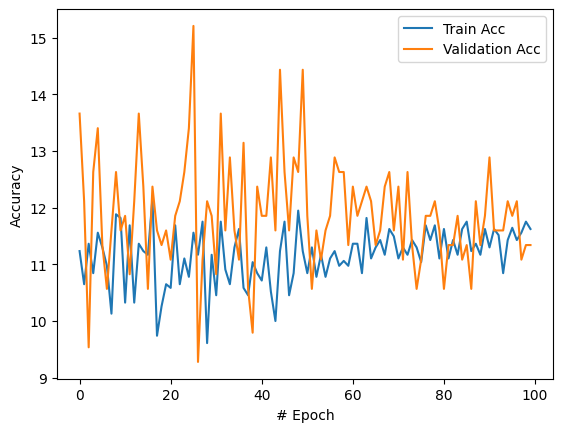

In [13]:
model_name = 'model_cnn3D_vid_skel_imit_acc'
epochs = 100
best_preds = train(model, model_name, prog_bar = False)

# Time Distributed CNN

In [12]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
#         x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        x_reshape = x.contiguous().view(x.size(0), x.size(1), -1, x.size(-1))  # (samples, timesteps, input_size)
        
#         print(x_reshape.shape)
        y = self.module(x_reshape)
#         print(y.shape)
        sqrt_dim = int(np.floor(y.shape[2]**0.5))

        # We have to reshape Y
        if self.batch_first:
#             y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
            y = y[:, :, :sqrt_dim**2, :].contiguous().view(x.size(0), y.size(1), sqrt_dim, sqrt_dim, y.size(-1))  # (samples, channels, output_size, timesteps)
        else:
            pass
#             y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size
#         print(y.shape)
#         print('end td')
        return y

In [13]:
class TD_CNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D
#         self.conv = nn.Sequential(TimeDistributed(nn.Conv2d(3, 32, 3)),
#                                   TimeDistributed(nn.MaxPool2d(2, 2)),
                                  
#                                   TimeDistributed(nn.Conv2d(32, 64, 3)),
#                                   TimeDistributed(nn.MaxPool2d(2, 2)),
                                  
#                                   TimeDistributed(nn.Conv2d(64, 128, 3)),
#                                   TimeDistributed(nn.MaxPool2d(2, 2))
#                  
        self.conv1 = TimeDistributed(nn.Conv2d(1, 32, 3))
        self.conv2 = TimeDistributed(nn.Conv2d(32, 64, 3))
        self.conv3 = TimeDistributed(nn.Conv2d(64, 128, 3))
        self.pool = nn.MaxPool3d((2, 2, 1))
        
        self.lstm = nn.LSTM(144, 128, num_layers=1)
        self.fc1 = nn.Linear(3686400, 16) # 3 layers: 14*14*128, 4 layers: 6*6*128
#         self.fc2 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(16, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.td(x)
        x = self.pool(F.relu(self.conv1(x)))
#         print('x:', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = self.conv(x)
        x = torch.flatten(x, 1, -2) # flatten all dimensions except batch
#         x = x.view()
#         x = F.relu(self.fc1(x))
#         x = self.fc(x)
#         x = self.drop(x)
        x, hidden = self.lstm(x)
        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc2(x))
#         x = self.drop(x)
        x = F.softmax(x)
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TD_CNN2D().to(device)
# summary(model, (3, 128, 128, max_seq_len))
print('device:', device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device: cuda


Epoch:  100/100 | Training Acc:  11.88 | Testing Acc:  10.36 , Best Testing Acc: 15.8


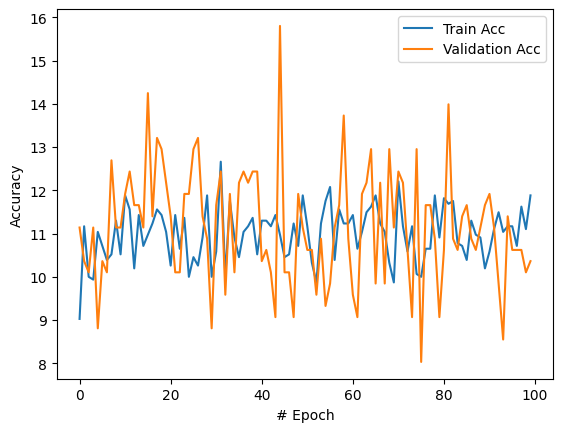

In [15]:
model_name = 'model_tdcnn2d_vid_imit_acc'
epochs = 100
best_preds = train(model, model_name, prog_bar = False)

In [16]:
acc = np.sum([1 for i in range(len(test_labels)) if test_labels[i] == best_preds[i]]) / len(test_labels) * 100
acc

15.844155844155845

## 2D-CNN

In [18]:
train_vids2 = np.swapaxes(np.squeeze(train_vids), 1, 3)
test_vids2 = np.swapaxes(np.squeeze(test_vids), 1, 3)
# train_vids2 = train_vids.reshape(train_vids.shape[0], 1, train_vids.shape[2],
#                                 train_vids.shape[3] * train_vids.shape[4])
# test_vids2 = test_vids.reshape(test_vids.shape[0], 1, test_vids.shape[2],
#                                 test_vids.shape[3] * test_vids.shape[4])
print(train_vids2.shape)
print(test_vids2.shape)

(1539, 150, 128, 128)
(385, 150, 128, 128)


In [21]:
batch_size = 32
training_data = CustomImageDataset(torch.from_numpy(train_vids2), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids2), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [22]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([32, 150, 128, 128])
Labels batch shape: torch.Size([32])


In [25]:
class CNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(150, 64, 3)
        self.conv11 = nn.Conv2d(64, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv21 = nn.Conv2d(128, 128, 3)
        self.conv3 = nn.Conv2d(128, 128, 3)
        self.conv31 = nn.Conv2d(128, 128, 3)
#         self.conv4 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(14*14*128, 128) # 3 layers: 14*14*128, 4 layers: 6*6*128
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         x = F.relu(self.conv11(x))
        x = self.pool(F.relu(self.conv2(x)))
#         x = F.relu(self.conv21(x))
        x = self.pool(F.relu(self.conv3(x)))
#         x = F.relu(self.conv31(x))
#         x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.softmax(self.fc3(x))
        return x

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN2D().to(device)
summary(model, (150, 128, 128))
print('device:', device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]          86,464
         MaxPool2d-2           [-1, 64, 63, 63]               0
            Conv2d-3          [-1, 128, 61, 61]          73,856
         MaxPool2d-4          [-1, 128, 30, 30]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
         MaxPool2d-6          [-1, 128, 14, 14]               0
           Dropout-7                [-1, 25088]               0
            Linear-8                  [-1, 128]       3,211,392
           Dropout-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 3,537,098
Trainable params: 3,537,098
Non-trainable params: 0
---------------------------

Epoch:  100/100 | Training Acc:  11.61 | Testing Acc:  9.62 , Best Testing Acc: 18.99


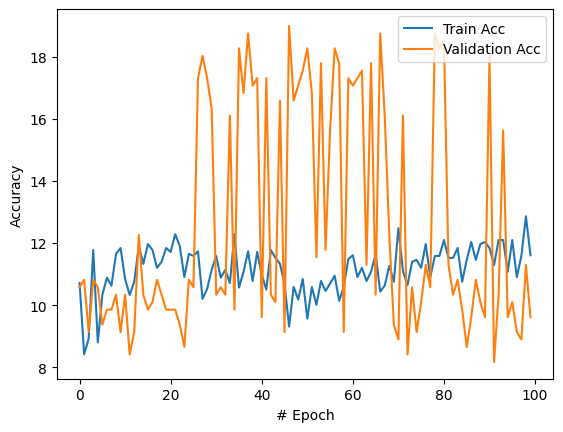

In [27]:
model_name = 'model_cnn2d_vid_imit_acc'
epochs = 100
best_preds = train(model, model_name, prog_bar = False)

In [28]:
acc = np.sum([1 for i in range(len(test_labels)) if test_labels[i] == best_preds[i]]) / len(test_labels) * 100
acc

12.467532467532468

## ResNet 3D

In [18]:
import pytorchvideo.models.resnet

def make_kinetics_resnet():
    
    return pytorchvideo.models.resnet.create_resnet(
      input_channel=1, # RGB input from Kinetics
      model_depth=50, # For the tutorial let's just use a 50 layer network
      model_num_class=10, # Kinetics has 400 classes so we need out final head to align
      norm=nn.BatchNorm3d,
      activation=nn.ReLU,
  )

In [9]:
[train_files, train_vids, _, train_labels, train_mask,
        test_files, test_vids, _, test_labels, test_mask] = load_pkl('../datasets/imit_ASL_10_vid_skel_256x256.pkl')
train_vids = np.swapaxes(train_vids, 1, 4)
test_vids = np.swapaxes(test_vids, 1, 4)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_vids.shape)
# print(train_skels.shape)
print(train_labels.shape)
print(train_mask.shape)

(1539, 1, 256, 256, 150)
(1539,)
(1539, 150)


In [16]:
batch_size = 1
training_data = CustomImageDataset(torch.from_numpy(train_vids), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [17]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([1, 1, 256, 256, 150])
Labels batch shape: torch.Size([1])


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet3d = make_kinetics_resnet().to(device)
# resnet3d
# summary(resnet3d, (1, 128, 128, 150))
print('device:', device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet3d.parameters(), lr=0.001)

device: cuda


In [23]:
model_name = 'model_resnet3d_vid_imit_acc'
epochs = 100
best_preds = train(resnet3d, model_name, prog_bar = False)

AssertionError: input for MultiPathWayWithFuse needs to be a list of tensors

In [ ]:
acc = np.sum([1 for i in range(len(test_labels)) if test_labels[i] == best_preds[i]]) / len(test_labels) * 100
acc

## Resnet18-lstm

In [19]:
[train_files, train_vids, _, train_labels, train_mask,
        test_files, test_vids, _, test_labels, test_mask] = load_pkl('../datasets/imit_ASL_10_vid_skel_rgb.pkl')
train_vids = np.swapaxes(train_vids, 2, 4)
test_vids = np.swapaxes(test_vids, 2, 4)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_vids.shape)
# print(train_skels.shape)
print(train_labels.shape)
print(train_mask.shape)

(1539, 150, 3, 128, 128)
(1539,)
(1539, 150)


In [19]:
train_vids = np.swapaxes(np.swapaxes(train_vids, 1, 2), 1, 4)
test_vids = np.swapaxes(np.swapaxes(test_vids, 1, 2), 1, 4)
print(train_vids.shape)
print(test_vids.shape)

(1539, 50, 3, 224, 224)
(385, 50, 3, 224, 224)


In [20]:
batch_size = 2
training_data = CustomImageDataset(torch.from_numpy(train_vids), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [21]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([2, 50, 3, 224, 224])
Labels batch shape: torch.Size([2])


In [22]:
from torch import nn
class Resnt18Rnn(nn.Module):
    def __init__(self):
        super(Resnt18Rnn, self).__init__()
        num_classes = 10
        dr_rate= 0.5
        pretrained = True
        rnn_hidden_size = 128
        rnn_num_layers = 2
        
        baseModel = torchvision.models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
#         y = self.baseModel((x[:, :, :, :, ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x 

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
resnet18 = Resnt18Rnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

device: cuda


Epoch:  36/100 | Training Acc:  12.6 | Testing Acc:  12.44 , Best Testing Acc: 16.32


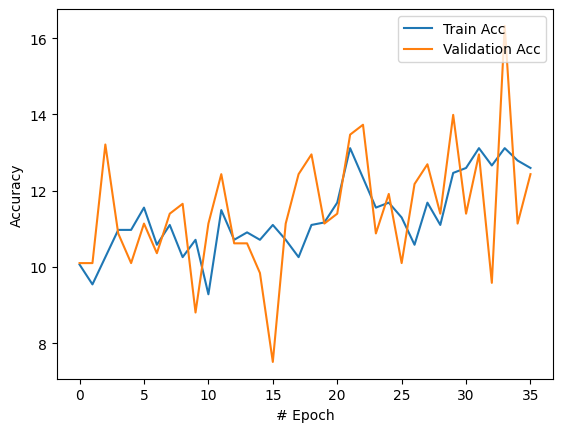

KeyboardInterrupt: 

In [24]:
model_name = 'model_resnet18lstm_vid_imit_acc'
epochs = 100
best_preds = train(resnet18, model_name, prog_bar = False)

In [ ]:
acc = np.sum([1 for i in range(len(test_labels)) if test_labels[i] == best_preds[i]]) / len(test_labels) * 100
acc

# Gray vid vgg16

In [12]:
[train_files, train_vids, train_skels, train_labels, train_mask,
        test_files, test_vids, test_skels, test_labels, test_mask] = load_pkl('../datasets/imit_ASL_10_vid_skel_224x224down.pkl')
# train_vids = np.swapaxes(train_vids, 1, 4)
# test_vids = np.swapaxes(test_vids, 1, 4)
# train_vids = train_vids.astype(np.float64)
# test_vids = test_vids.astype(np.float64)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_vids.shape)
print(train_skels.shape)
print(train_labels.shape)
print(train_mask.shape)

(1539, 50, 224, 224)
(1539, 150, 3, 42)
(1539,)
(1539, 150)


In [13]:
batch_size = 32
training_data = CustomImageDataset(torch.from_numpy(train_vids), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [14]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([32, 50, 224, 224])
Labels batch shape: torch.Size([32])


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.fc = torch.nn.Sequential(
    nn.Linear(
        in_features=2048,
        out_features=10
    ),
    nn.Softmax()
)
vgg16.to(device).eval()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.002)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=10, factor=0.5)

device: cuda


In [16]:
model_name = 'model_vgg16_withTL_vid_imit_acc'
epochs = 200
best_preds = train(vgg16, model_name, prog_bar = False)

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 50, 224, 224] to have 3 channels, but got 50 channels instead

## resnet 3d

In [8]:
[train_files, train_vids, train_skels, train_labels, train_mask,
        test_files, test_vids, test_skels, test_labels, test_mask] = load_pkl('../datasets/imit_ASL_10_vid_skel_224x224rgb_down.pkl')
train_vids = np.swapaxes(train_vids, 1, 4)
test_vids = np.swapaxes(test_vids, 1, 4)
# train_vids = train_vids.astype(np.float64)
# test_vids = test_vids.astype(np.float64)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_vids.shape)
print(train_skels.shape)
print(train_labels.shape)
print(train_mask.shape)

(1539, 3, 224, 224, 50)
(1539, 150, 3, 42)
(1539,)
(1539, 150)


In [9]:
batch_size = 2
training_data = CustomImageDataset(torch.from_numpy(train_vids), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [10]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([2, 3, 224, 224, 50])
Labels batch shape: torch.Size([2])


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
resnet = torchvision.models.video.r3d_18(pretrained=True)
resnet.fc = torch.nn.Sequential(
    nn.Linear(
        in_features=512,
        out_features=10
    ),
    nn.Softmax()
)
resnet.to(device).eval()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.002)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=10, factor=0.5)

device: cuda


Epoch:  12/200 | Training Acc:  8.7 | Testing Acc:  8.29 , Best Testing Acc: 8.29


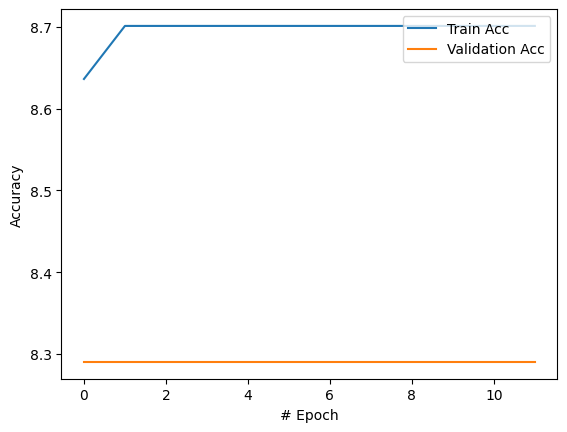

KeyboardInterrupt: 

In [12]:
model_name = 'model_r3d_18_withTL_vid_imit_acc'
epochs = 200
best_preds = train(resnet, model_name, prog_bar = False)

## vgg16-lstm

In [8]:
[train_files, train_vids, train_skels, train_labels, train_mask,
        test_files, test_vids, test_skels, test_labels, test_mask] = load_pkl('../datasets/imit_ASL_10_vid_skel_224x224rgb_down.pkl')
train_vids = np.swapaxes(train_vids, 2, 4)
test_vids = np.swapaxes(test_vids, 2, 4)
# train_vids = train_vids.astype(np.float64)
# test_vids = test_vids.astype(np.float64)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_vids.shape)
print(train_skels.shape)
print(train_labels.shape)
print(train_mask.shape)

(1539, 50, 3, 224, 224)
(1539, 150, 3, 42)
(1539,)
(1539, 150)


In [9]:
batch_size = 1
training_data = CustomImageDataset(torch.from_numpy(train_vids), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [10]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([1, 50, 3, 224, 224])
Labels batch shape: torch.Size([1])


In [11]:
from torch import nn
class Vgg16Rnn(nn.Module):
    def __init__(self):
        super(Vgg16Rnn, self).__init__()
        num_classes = 10
        dr_rate= 0.5
        pretrained = True
        rnn_hidden_size = 128
        rnn_num_layers = 1
        
        baseModel = torchvision.models.vgg16(pretrained=pretrained)
        num_features = 1000  # output of vgg16
#         baseModel.fc = Identity()
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
#         print(x.shape)
        ii = 0
#         y = self.baseModel((x[:,ii]))
# #         y = self.baseModel((x[:, :, :, :, ii]))
#         output, (hn, cn) = self.rnn(y.unsqueeze(1))
#         for ii in range(1, ts):
#             y = self.baseModel((x[:,ii]))
#             out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        vggout = torch.zeros(b_z, ts, 1000).to(device)
            
        for t in range(ts):
            vggout[:, t, :] = self.baseModel((x[:,t]))
        out, (hn, cn) = self.rnn(vggout)
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
vgg16 = Vgg16Rnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=20, factor=0.5)

device: cuda


Epoch:  4/200 | Training Acc:  9.49 | Testing Acc:  10.13 , Best Testing Acc: 11.69


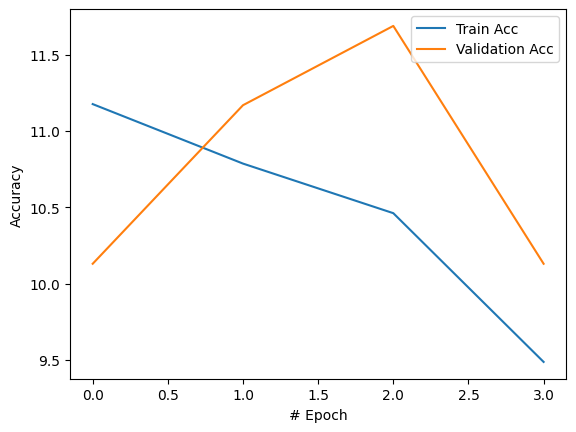

KeyboardInterrupt: 

In [13]:
model_name = 'model_vgg16lstm_vid_imit_acc'
epochs = 200
best_preds = train(vgg16, model_name, prog_bar = False)

In [ ]:
acc = np.sum([1 for i in range(len(test_labels)) if test_labels[i] == best_preds[i]]) / len(test_labels) * 100
acc